# Guia rápido para o `ykktmm`

O módulo tem objetivo de abstrair a maior parte da matemática envolvida no método das matrizes de transferência. Tornando a prototipagem de materiais um joguinho de lego

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#importando o módulo
import ykktmm as tmm

O módulo é composto de duas classes principais: a classe `material` e a classe `layer`.

### A Classe Layer
`layer` representa uma única matriz de transferência, podendo ter 3 tipos de associação:
* `assoc='>'`: Uma seção normal de duto
* `assoc='//'`: Uma seção de duto lateral
* `assoc='||'`: Uma seção de tipo barreira

Caso argumentos de número de onda e impedância não sejam passados para a layer, o `tmm.material` assume $z_c = \rho_0 c_0$ e $k = \omega / c_0$ na inicialização da classe. Essas variáveis podem ser alteradas diretamente caso haja necessidade de utilizar modelo dissipativo, exemplo:
```
tmm.c0 = 343 + 2j
```

In [2]:
z_cav = 1 #Aqui seria a formula da impedância que você quer

camadas = [
    tmm.layer(area=1, tam=0.2),
    tmm.layer(area=1, tam=0.1, zc=z_cav, assoc="//"),
    tmm.layer(area=2, tam=0.3),
    tmm.layer(area=1, tam=0.1)
    ]


### A Classe Material
`material` representa o conjunto de todas as matrizes de transferência. Sendo necessário passar como argumento uma lista contendo todas as camadas e o vetor de frequência

In [3]:
f = np.arange(20,2000) #vetor de frequencias
mat = tmm.material(layers=camadas,freq=f)

#### Operações
Com a classe inicializada, é possível realizar as operações esperadas para a classe

In [4]:
#Obtem a impedância de superfície do material
zs = mat.solveZs() #Caso nenhum argumento seja passado, a função assume paredes rígidas

#Obtem a matriz de transferência resultante
tg = mat.solveTg()

#define as condições de contorno(pode ser definida na inicialização do tmm.material)
mat.setBound(p0=1,q0=2)
p1,q1 = mat.solveEq() #retorna a pressão e velocidade de volume no material

### A Classe utils

A classe utils apenas engloba pequenas funções úteis em Acústica

In [6]:
alpha = tmm.utils.absort(zs) #retorna o coeficiente de absorção dado um valor zs
NPS = tmm.utils.dB(1,ref=20E-6) #retorna o valor passado em dB
zc,kc= tmm.utils.delany_basley(f,sigma=10000) #É isso mesmo que ta escrito

Obviamente você pode encurtar a classe né... O código abaixo faz a exata mesma coisa

In [7]:
from ykktmm import utils

alpha = utils.absort(zs)
NPS = utils.dB(1,ref=20E-6)
zc,kc= utils.delany_basley(f,sigma=10000)

# Exemplos

Os dados obtidos através do TMM estão sendo comparados com as equações do Acústica de Salas, considerando modelo de ondas planas sem dissipação

### Absorvedor Membrana

Um absorvedor de membrana pode ser representado como uma matriz do tipo barreira `assoc='||'`, e duas matrizes de fluído equivalente `assoc='>'`.

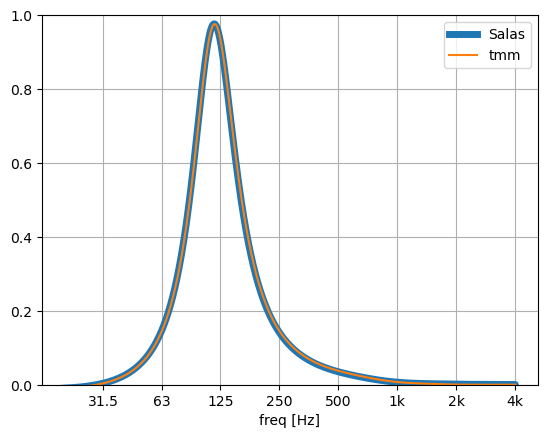

In [3]:
import pandas as pd
freq = np.arange(20,4E3,1E-2) #Vetor de frequencias

#Plot dos dados de Acustica de Salas
benchmark = pd.read_csv(r"benchmark\membrana\membrana_0_data.csv").to_numpy()
plt.plot(freq,benchmark,label="Salas",linewidth=5)


#TMM
zp,kp = tmm.utils.delany_basley(freq,sigma=10440)
m = 485* 3E-3 #m'' = rho_m * t_m
zplaca = 1j*(2*np.pi*freq)*m #z = jwm''

mat = tmm.material(layers=[
    tmm.layer(area=1, zc=zplaca, assoc="||"),
    tmm.layer(area=1, tam=15E-2*0.2),
    tmm.layer(area=1, tam=0.8*15E-2, zc=zp, kc=kp)
    ],freq=freq)

zs = mat.solveZs() #
plt.plot(freq,tmm.utils.absort(zs),label="tmm")

#Configurando o plot
plt.xlabel("freq [Hz]")
plt.grid()
plt.xscale("log")
plt.ylim([0,1])
plt.legend()
tmm.utils.plot_cuxticks(); #muda as marcações do eixo x

### Poroso + Airgap

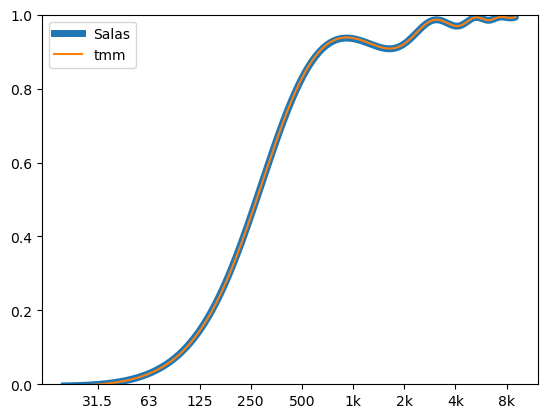

In [10]:
freq = np.arange(20,9000,1E-2)

#Plot dos dados de Acustica de Salas
benchmark = pd.read_csv(r"benchmark\poroso\poroso_0_data.csv").to_numpy()
benchmark=np.append(benchmark,1)
plt.plot(freq,benchmark,label="Salas",linewidth=5)


#TMM
zp,kp = tmm.utils.delany_basley(freq,sigma=20610)
mat = tmm.material(layers=[
    tmm.layer(area=1,tam=5E-2,zc=zp,kc=kp),
    tmm.layer(area=1,tam=2.5E-2)
    ], freq=freq)

zs = mat.solveZs()
alpha = tmm.utils.absort(zs)
plt.plot(freq,alpha,label="tmm")

#Configurando o plot
plt.xscale("log")
plt.ylim([0,1])
plt.legend()
tmm.utils.plot_cuxticks();